# Project - Implementing a Self-balancing robot using Neural Networks and simulating on Vrep software using a python script

Yashad Samant - yashad.samant@colostate.edu

### Objective

Aim is to develop a two wheeled system which can balance on its own. Project is based on http://ieeexplore.ieee.org/document/4667312/ which incorporates the use of Fuzzy neural networks and reinforcement learning to achieve the objective. 
Achieved objectives are as follows -:

* Developed a system by interfacing MPU 6050 with raspberry pi 3 and obtained values from 3-axis accelerometer & 3-axis gyroscope.
* Combined the raw values from 3-axis accelerometer and 3-axis gyroscope using complementary filter and obtained the target output, rotation along x and rotation along y. Thus, this network will have 6 inputs and 2 outputs.
* Based on the output obtained from the filter, generated a table with respective inputs and desired outputs, gave it to input and target vector and ran it through two different neural networks.
* Ran the simulations on Vrep software using a python script based on the test implementation of the trained neural network.
* Plot necessary data related to the algorithms and generate a document.

### Introduction

PID controllers have been widely used for the control of machines in various applications. But we also know that the amount of manipulation and estimation required while developing a PID controller is immense and hence, finding a better to achieve efficiency and accuracy while also keeping the design process simple is the need of the hour. In this project, I have tried to implement self-balancing robot using neural networks where it controls the the angle obtained from the accelerometer and gyroscope using the complementary filter and reduces the error between actual and desired value thus maintaining the balance of the robot.  

### Required Code

Here, I have imported all the necessary libraries required for the code. It also includes the dependecies required for the Neural Networks. I have implemented two neural networks in this project. One is where I can change the number of hidden layers and number of neurons in those layers. Other one is a five layer neural network where first layer is based on membership functions derived from fuzzy logic.
* numpy for matrix operations
* matplotlib for plotting data
* IPython.display for displaying images of simulations and neural network structure
* skfuzzy for fuzzy neural network
* membershipfunction is the anfis dependency which has the base code for membership function design
* mfderivs has the centroid implementation involved in fuzzy logic
* neuralnetworks, scaledgradientconjugate and mlutils are the dependencies for neural network designed in class
* math is used to design complementary filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import anfis as anfis
from IPython.display import Image
import skfuzzy as fuzz
import anfis
import membershipfunction as mfunc
import mfDerivs as mfd
from IPython.display import Image
%matplotlib inline
import neuralnetworks as nn
nnet = nn.NeuralNetwork
import mlutils as ml
import scaledconjugategradient as scg
import math
import time

#### Raspberry Pi Interface with MPU 6050

* Raspberry pi 3 is the third generation of pi and a computer in itself. It has his own operating system Raspbian which makes it  easy to interface the GPIO pins. It has Quad Core 1.2GHz Broadcom BCM2837 64bit CPU, 1GB RAM, BCM43438 wireless LAN and Bluetooth Low Energy (BLE) on board, 40-pin extended GPIO, 4 USB 2.0 ports, 4 Pole stereo output and composite video port, Full size HDMI, CSI camera port for connecting a Raspberry Pi camera, DSI display port for connecting a Raspberry Pi touchscreen, display, Micro SD port for loading your operating system and storing data, Upgraded switched Micro USB power source up to 2.5A. 
* The MPU-6050 devices combine a 3-axis gyroscope and a 3-axis accelerometer on the same silicon die, together with an onboard Digital Motion Processor™ (DMP™), which processes complex 6-axis MotionFusion algorithms. We can obtain data (digital)from the sensor using SPI or I2C communication channel. 
* Interfacing of rasberry pi and mpu 6050 was done using the I2C channel on raspberry pi and SCI/ SPI on mpu 6050. Then found out the channel number for I2C on pi and obtained the values from accelerometer and gyroscope.
* Used the interface to obtain real test values.

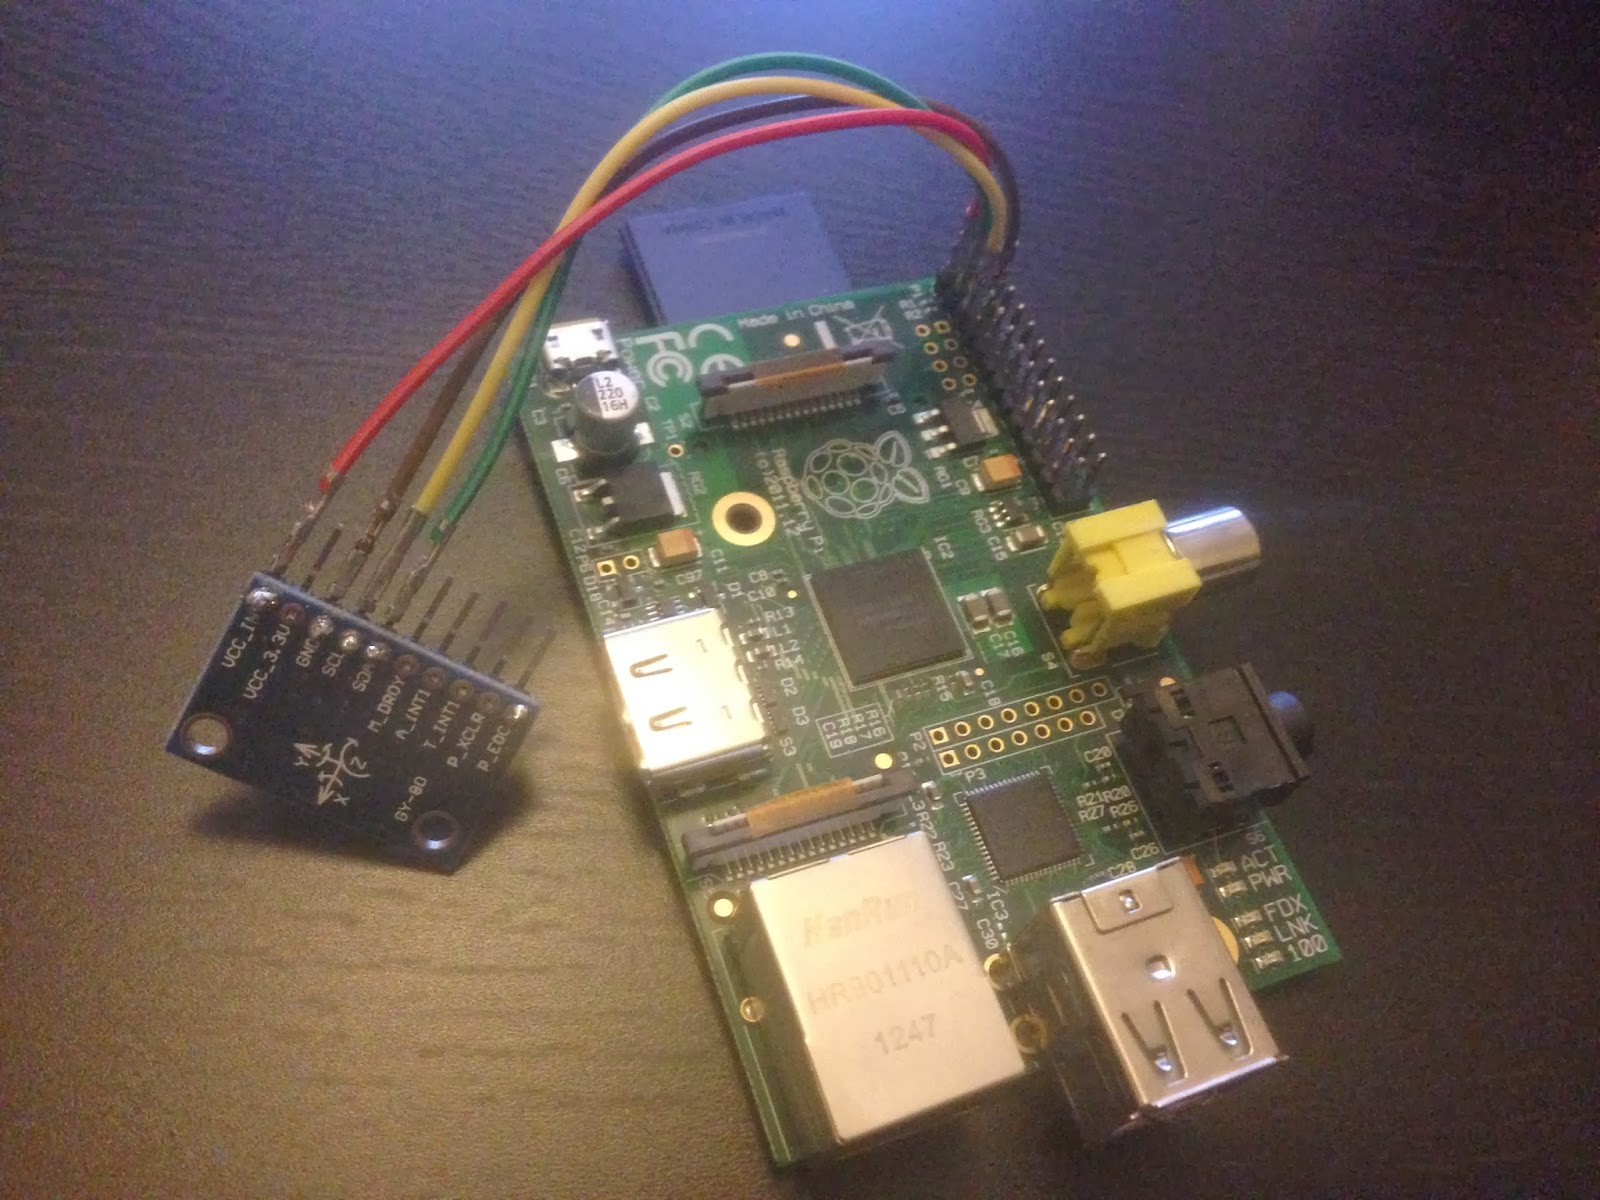

In [23]:
Image("C:/Users/Yashad/Desktop/IMG-20171210-WA0007.jpg")

Interface diagram is shown below:

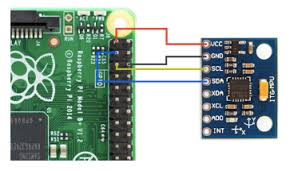

In [24]:
Image("C:/Users/Yashad/Desktop/download.jpg")

### Data Extraction

#### Complementary Filter Implementation for generating data 

In [2]:
# Calculating manhattan distance between x and y
def dist(a, b):
    return math.sqrt((a * a) + (b * b))

# calculating rotation along y axis 
def get_y_rotation(x,y,z):
    radians = math.atan2(x, dist(y,z))
    return -math.degrees(radians)

# calculating rotation along x axis 
def get_x_rotation(x,y,z):
    radians = math.atan2(y, dist(x,z))
    return math.degrees(radians)

# combining the values of accelerometer and gyroscope by taking offsets from gyroscopes into consideration
def complementary_filter(accelx, accely, accelz, gyrox, gyroy, gyroz):
    last_x = get_x_rotation(accelx, accely, accelz)
    last_y = get_y_rotation(accelx, accely, accelz)
    gyro_offset_x = gyrox
    gyro_offset_y = gyroy
    gyro_total_x = (last_x) - gyro_offset_x
    gyro_total_y = (last_y) - gyro_offset_y
    return gyro_total_x, gyro_total_y

In this project, along with rasberry pi MPU-6050 interface, just to obtain more data, I have extracted data from kaggle - https://www.kaggle.com/vmalyi/run-or-walk/data.

Here, they have collected 88588 samples from iphone which gives the time-stamp, 3-axis accelerometer values and 3-axis gyroscope values.

As its a .csv file, I have loaded the text using np.loadtxt and strip the byte characters associated with it. In the next step, I just segregate the names, input and target output.

In [3]:
data = np.loadtxt("C:/Users/Yashad/Desktop/git/Artificial-Intelligence/AI_project/acc_gyro.csv", dtype = str, delimiter=',', usecols = range(5,11))
data = np.chararray.strip(data[0:],'b')
data = np.chararray.strip(data[0:],"'\'")
names = data[0]
X = data[2:, :]
X = np.asarray(X,dtype=float)
updated_data = []
T = []
for i in range(data.shape[0]-2):
    angle_x, angle_y = complementary_filter(X[i][0], X[i][1], X[i][2], X[i][3], X[i][4], X[i][5])
    T.append((angle_x, angle_y))
T = np.asarray(T)
T = T.reshape(88587,2)
T

array([[-57.45964532, -30.38246237],
       [-72.34501124, -16.62333192],
       [-68.87748009, -19.93679115],
       ..., 
       [-63.97060588, -20.45937893],
       [-71.02584796, -17.18788385],
       [-67.90922917, -22.37063961]])

When implementing neural nets, its mandatory to obatin the relation between the target vector and each input vector, thus a relationship between them is plotted below.

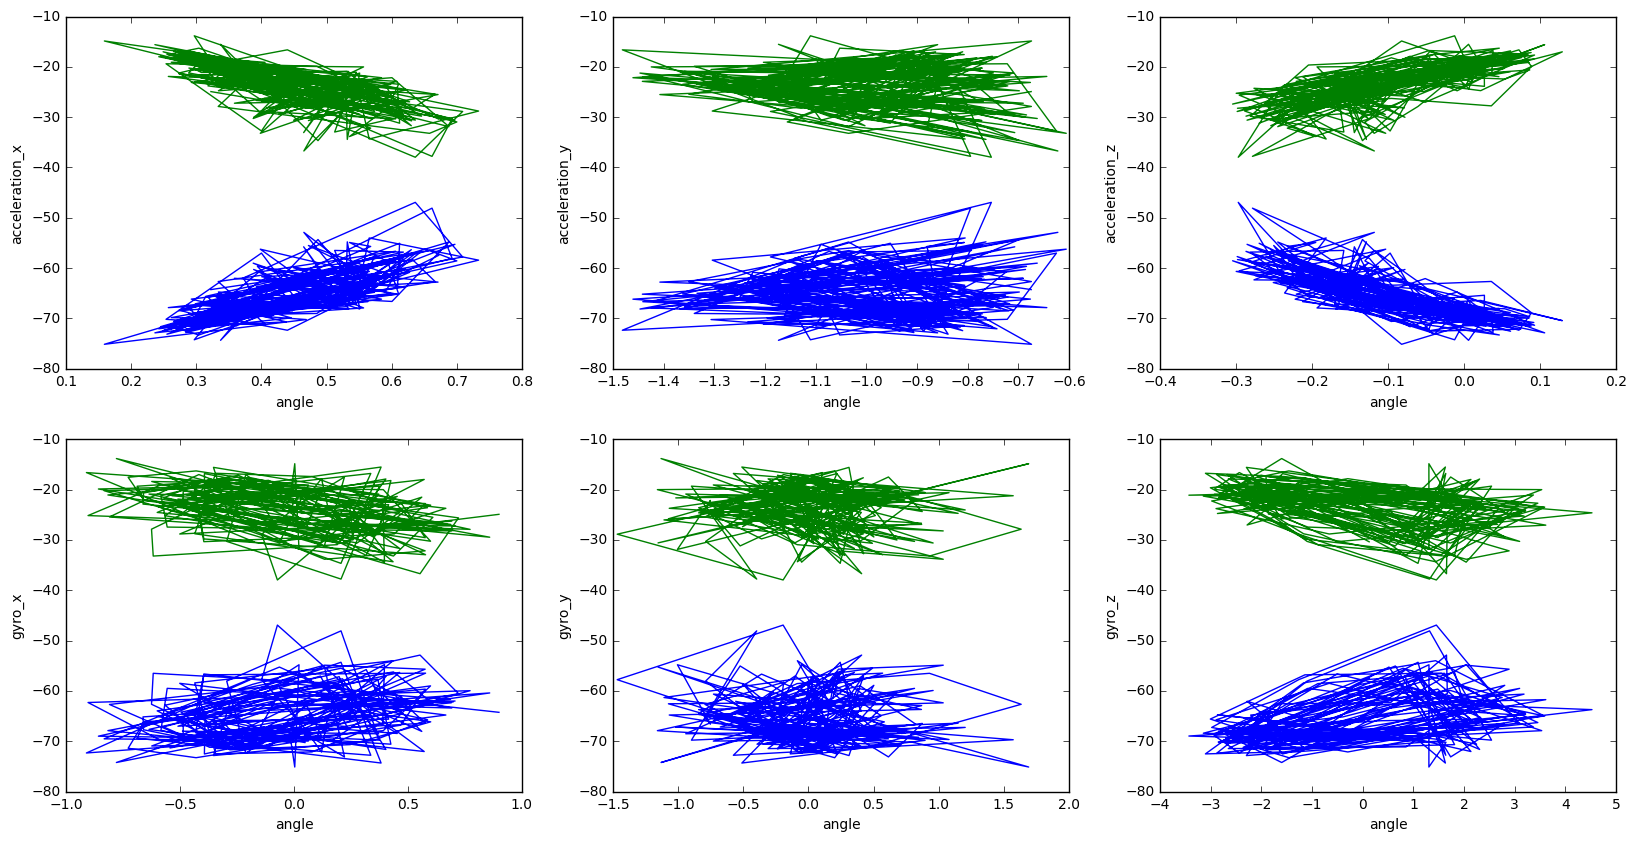

In [4]:
Tname = 'angle' 
plt.figure(figsize=(20,10))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(2,3, c+1)
    plt.plot(X[:200,c],T[:200,],'-')
    plt.ylabel(names[c])
    plt.xlabel(Tname)

* From the relationship between input and output, we could see that we have almost the mirror images in the graphs. That maybe because the upper and lower bounds of the sensor is fixed and the data generated is for all the points in the orientation. Thus, data might be taken in all the orientations.
* Also, we can see that the sensor was not sensitive for angles between -30 and -50 degrees.

### Methods

#### Neural Network

In the code below, I have designed a function which divides the data into train and test data and trains the neural network on the basis of train data and tests it on test data. 

In [5]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    results=[] 
    for i in range(len(hiddenLayerStructures)):
        rmse_train = []
        rmse_test = []
        t0 = time.time()
        for j in range(numberRepetitions):  
            Xtrain,Ttrain,Xtest,Ttest = ml.partition(X,T,(trainFraction,1-trainFraction),classify)
            if classify==False:
                nnet = nn.NeuralNetwork(X.shape[1], hiddenLayerStructures[i], T.shape[1])
            else:                      
                uniqT=np.unique(T)
                nnet=nn.NeuralNetworkClassifier(X.shape[1],hiddenLayerStructures[i],len(uniqT))
            nnet.train(Xtrain, Ttrain, numberIterations)
            Ytrain=nnet.use(Xtrain)
            Ytest=nnet.use(Xtest) 
            if classify==False:
                rmse_train.append(np.sqrt(np.mean((Ytrain-Ttrain)**2)))
                rmse_test.append(np.sqrt(np.mean((Ytest-Ttest)**2)))    
            else:
                rmse_train.append(np.sum(Ytrain!=Ttrain)/len(Ttrain))
                rsme_test.append(np.sum(Ytest!=Ttest)/len(Ttest))                
   
        results.append([hiddenLayerStructures[i],rmse_train,rmse_test,time.time()-t0])
    
    return results

Here, I have implemented a code to find the best set of data for all the networks

In [6]:
def summarize(result):
    results = []
    for i in range(len(result)):
        rmse_train = np.mean(result[i][1])
        rmse_test = np.mean(result[i][2])
        final_output = [result[i][0], rmse_train, rmse_test, result[i][3]]
        print()
        results.append(final_output)
    return results
    

In the code below, I have implemented a code which finds the best configuration of neural network on the basis of the rmse error

In [7]:
def bestNetwork(result):
    lowest = []
    for i in range(len(result)):
        lowest.append(result[i][2])
    minimum = np.min(lowest)
    l = lowest.index(minimum)
    return result[l]
            

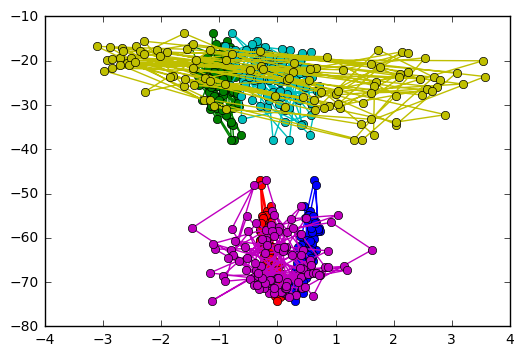

In [8]:
# plot the data using matplotlib.plot
plt.plot(X[:100,:], T[:100,], 'o-');

In this graph, we have plotted angle v/s sensor response. We can observe the trend that training data observed. The six colors represent the data from 3-axis accelerometer and 3-axis gyroscope making it six inputs for the neural network. The output for the training data comes from the complementary filter. Using the data from  the filter and feedback loop from the neural network, we have calculated the change in actual and desired angle and on the basis of the root-mean-square error value, we have achieved change in torque. 

Designed a neural network having 6 inputs as suggested by X with 2 outputs. This neural network is designed to have five layers, each having 20 firing neurons. Though we have seen that after three hidden layers, the efficiency of the code seems to drop irrespective of the time taken. I have tried this as the scg was not converging even after 1000 iterations. 

In [9]:
nnet = nn.NeuralNetwork(6, [20, 20, 20, 20, 20], 2)
nnet.train(X, T, 1000)
nnet.getErrorTrace()

array([ 0.70710678,  0.6692223 ,  0.6692223 , ...,  0.00725778,
        0.00725418,  0.00724789])

In [10]:
results = trainNNs(X, T, 0.8, [2, 10, 50, 100, [5, 5], [10, 10], [20, 20]], 5, 100, classify=False)
results
summary = summarize(results)
best = bestNetwork(summary)
print ('Summary of the results is as follows: -')
print (summary)
print ('Best configuration of neural net is:')
print (best)








Summary of the results is as follows: -
[[2, 8.6913803554104767, 8.6662138597290781, 29.480786323547363], [10, 3.6190798447131471, 3.6321572706347718, 74.67724537849426], [50, 3.0320782486135855, 3.0324835157496985, 276.62146639823914], [100, 3.0353175577065259, 3.0180921713436035, 532.8378593921661], [[5, 5], 3.9723997221421619, 3.9437161363555875, 72.90409421920776], [[10, 10], 2.7883904937782273, 2.8085052044679615, 121.40326762199402], [[20, 20], 2.2304727453930786, 2.2226728403436082, 233.84568119049072]]
Best configuration of neural net is:
[[20, 20], 2.2304727453930786, 2.2226728403436082, 233.84568119049072]


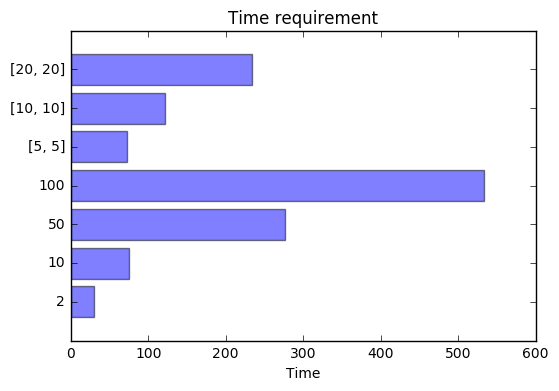

In [11]:
objects = []
time = []
for i in range(len(summary)):
    objects.append((summary[i][0]))
    y_pos = np.arange(len(objects))
    time.append(summary[i][3])
 
plt.barh(y_pos, time, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Time')
plt.title('Time requirement')

*	In this plot, we have designed neural networks when it comes to hidden units in each layer and the number of hidden layers. Thus, the x coordinate indicates the number of layers and y suggests the number of units in a hidden layer. The single digit indicates the number of neurons in each of the five layers
*	We can observe the time requirement by each of the layers. We can see that 100 hidden units in each layer took the maximum amount of time. [20, 20] had the best performance of the layers and we can see that we code was completed in around 200 seconds. The data plotted above is for [20, 20] as it had the lowest rmse error.


### Results from neural network

* From the results obtained for different configuration, we can observe that [20,20] provides the best output with train error of  2.43 and test error of 2.45.
* We can also see that the time taken increases with the increase in complexity of the neural network. Thus, the best combination has also taken more time to converge (233s).
* Also, we can see the time taken to obtain optimal result for other configuration.

Implemented the code on the best configuration of neural network to plot the results in  a systemantic manner. 

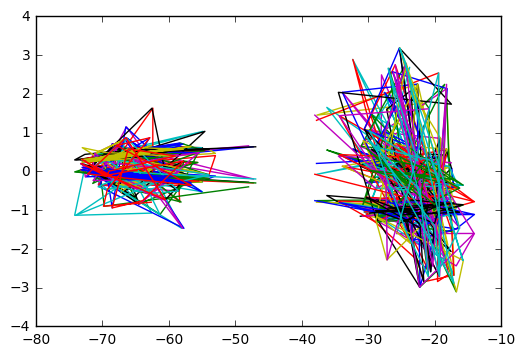

In [12]:
for j in range(10):  
    Xtrain,Ttrain,Xtest,Ttest = ml.partition(X[:100, :],T[:100, :],(0.8,0.2),False)
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [20,20], Ttrain.shape[1])
    nnet.train(Xtrain, Ttrain, 1000)
    Ytrain=nnet.use(Xtrain)
    Ytest=nnet.use(Xtest) 
    plt.plot(Ytest, Xtest) 

In this plot above, we see that this is the test output from layer 5. We can observe that we have achieved a good response when it comes to the trained output in fig1 and test output here. Thus, from this graph we become sure that the neural networks is working fine and is replicating the results we achieved from the trained network.


------------------------------------------------------------
Regression Example: Self-Balancing Robot
scg stopped after 1001 iterations: did not converge
Final RMSE: train 0.563871293174 test 0.286499271561


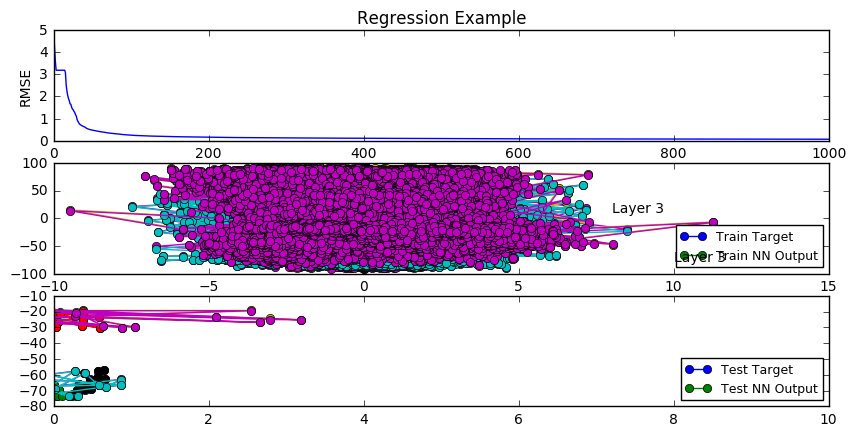

In [13]:
plt.ion()  # for use in ipython

print( '\n------------------------------------------------------------')
print( "Regression Example: Self-Balancing Robot") 
    
nnet.train(X,T,errorPrecision=1.e-10,weightPrecision=1.e-10,nIterations=1000)
print( "scg stopped after",nnet.getNumberOfIterations(),"iterations:",nnet.reason)
Y = nnet.use(X)
Ytest,Ztest = nnet.use(Xtest, allOutputs=True)
print( "Final RMSE: train", np.sqrt(np.mean((Y-T)**2)),"test",np.sqrt(np.mean((Ytest-Ttest)**2)))


plt.figure(figsize=(10,10))
    
nHLayers = len(nnet.nhs)

plt.subplot(6,1,1)
plt.plot(nnet.getErrorTrace())
plt.xlabel('Iterations');
plt.ylabel('RMSE')
    
plt.title('Regression Example')
plt.subplot(6,1,2)
plt.plot(X,T,'o-')
plt.plot(X,Y,'o-')
plt.text(8,12, 'Layer {}'.format(nHLayers+1))
plt.legend(('Train Target','Train NN Output'),loc='lower right',prop={'size':9})
plt.subplot(6,1,3)
plt.plot(Xtest,Ttest,'o-')
plt.plot(Xtest,Ytest,'o-')
plt.xlim(0,10)
plt.text(8,12, 'Layer {}'.format(nHLayers+1))
plt.legend(('Test Target','Test NN Output'),loc='lower right',prop={'size':9})
colors = ('blue','green','red','black','cyan','orange')  

We have plotted three plots above which gives the summary and the success of the code. 
*	In the first plot, we can observe that the rmse error is exponentially going to 0. This means that we have achieved a good response from our supervised neural network where the actual output have converged well towards the target output. We ran this code for 1000 iterations but we can see that we obtained respectable results in 200 iterations itself. 
*	Second plot is a bit strenuous to understand as it consists of approximately 90000 instances from the data set. Though it has many instances, it’s the weight trained for the third layer of the network.
*	We can observe the weights from the test data here which are similar to weights from layer 1 and 2.


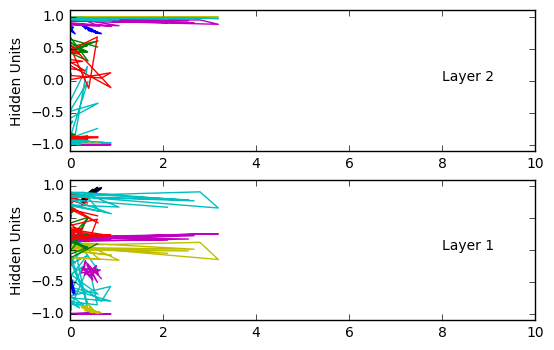

In [14]:
c= 1
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nHLayers,1,c)
    plt.plot(Xtest,Ztest[layer]) #,color=colors[i])
    plt.xlim(0,10)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Hidden Units')
    plt.text(8,0, 'Layer {}'.format(layer+1))
    c+=1
c = 0

In the plot above, we observe the trained weights in layer one and layer two. We can see the weights are significantly big and equally scaled for all the inputs. This makes it easier for us to use the weights as it is, otherwise we had to scale the inputs to be relatively close to each other to avoid the probem of unequal scale of weights (where a input having higher arithmatic value will obtain higher weights thus increasing it’s effect on the output).

3.13714306358 4.4357962817e-07 108.506944444
3.47058760869 0.207984779454 108.506944444


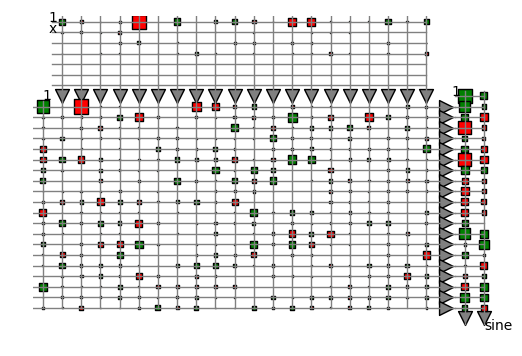

In [15]:
nnet.draw(['x'],['sine'])
plt.draw()

This plot above gives the structure of the neural net where red are weights which negatively impacts the neural network while green impacts positively.

#### BACKGROUND OF FUZZY LOGIC

Fuzzy logic is a form of many-valued logic in which the truth values of variables may be any real number between 0 and 1. By contrast, in Boolean logic, the truth values of variables may only be the integer values 0 or 1. Fuzzy logic has been employed to handle the concept of partial truth, where the truth value may range between completely true and completely false. Furthermore, when linguistic variables are used, these degrees may be managed by specific (membership) functions.

Since the fuzzy system output is a consensus of all of the inputs and all of the rules, fuzzy logic systems can be well behaved when input values are not available or are not trustworthy. Weightings can be optionally added to each rule in the rulebase and weightings can be used to regulate the degree to which a rule affects the output values. These rule weightings can be based upon the priority, reliability or consistency of each rule. These rule weightings may be static or can be changed dynamically, even based upon the output from other rules.

https://en.wikipedia.org/wiki/File:Fuzzy_logic_temperature_en.svg


* Fuzzify all input values into fuzzy membership functions.
* Execute all applicable rules in the rulebase to compute the fuzzy output functions.
* De-fuzzify the fuzzy output functions to get "crisp" output values.

Fuzzy logic in Matlab gives a good visual representation of it.

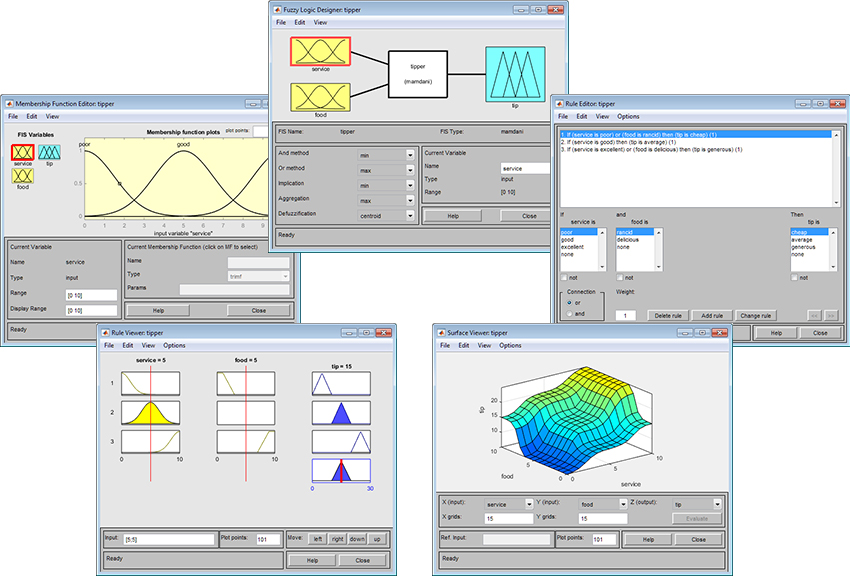

In [16]:
Image("C:/Users/Yashad/Desktop/Books/machine learning/1469941085480.jpg")

#### Fuzzy Neural Network

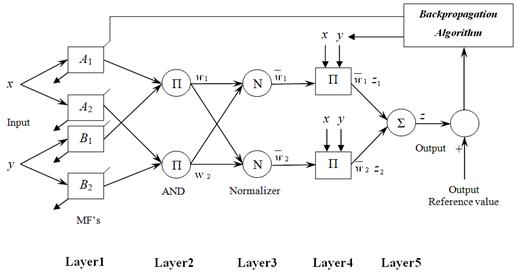

In [17]:
Image("C:/Users/Yashad/Desktop/Books/machine learning/image010.jpg")

We assume the fuzzy inference system under consideration has two inputs x and y and one output z. Suppose that the rule base contains two fuzzy if-then rules of Takagi and Sugeno’s type.
Rule 1: If x is A1 and y is B1, then fi = plx + q1y+ rl,
Rule 2: If x is A2 and y is B2, then f 2 = p2x + q2y+ 7-2.
The node functions in the same layer are of the same function family as described below:
 
Layer 1: Every node i in this layer is a square node with a node function
 $$O^1_i = \mu_A(x)$$
 
Layer 2: Every node in this layer is a circle node labeled Tz which multiplies the incoming signals and sends the product out. For instance,
 $$w_i = \mu_A(x)*\mu_B(y), i = 1,2$$
 
Layer 3: Every node in this layer is a circle node labeled N. The ith node calculates the ratio of the ith rule’s firing strength to the sum of all rules’ firing strengths:
 $$w_m = \frac{w_i}{w_1+w_2}, i=1,2 $$
 
Layer 4: Every node i in this layer is a square node with a node function

$$O^4_i = w_mf_i = w_i(p_ix+q_iy+r_i)$$ 

Layer 5:The single node in this layer is a circle node labeled C that computes the overall output as the summation of all incoming signals, i.e.,

$$O^5_i = \sum_iw_mf_i = \frac{\sum_iw_if_i}{\sum_iw_i}$$

Thus, here we have a general model of **ANFIS**. I have used Mamdani method to design the membership function of the anfis system. It gives a non-linear approximation of all the input variables. We need not zero mean the input seaparately as the fuzzification process involves standardization which. Then, values obtained from different inputs are processed using the centroid method. But we have seen in the fuzzy logic section that there is no training involved and just calculation of final values based on the input. But in case of anfis we have target values, using backpropagation and/or least mean square error, we change the weights thus training the neural net as we can see in the above model. 

Thus, it is a combination of fuzzy logic using which output is obtained and neural net where the net is trained using the target values.

#### Example of Fuzzy Neural Network

In [18]:
fert_convert = lambda x: 0 if b'N' in x else 1
data = np.loadtxt('C:/Users/Yashad/Desktop/git/Machine-Learning/fertility.txt', delimiter=',', converters={9: fert_convert})

X = data[:,:-1]
T = data[:,-1].reshape( (X.shape[0], 1))

#ANFIS
X = data[:,0:5]
T = data[:,-1].reshape( (X.shape[0], ))
mf = [[['gaussmf',{'mean':-0.33,'sigma':0.1}],['gaussmf',{'mean':0.33,'sigma':0.1}],['gaussmf',{'mean':-1,'sigma':0.1}],['gaussmf',{'mean':1,'sigma':0.1}]],
     [['gaussmf',{'mean':0.55,'sigma':0.075}],['gaussmf',{'mean':0.65,'sigma':0.075}],['gaussmf',{'mean':0.75,'sigma':0.075}],['gaussmf',{'mean':0.9,'sigma':0.105}]],
     [['gaussmf',{'mean':0.0,'sigma':0.1}],['gaussmf',{'mean':1.0,'sigma':0.1}]],
     [['gaussmf',{'mean':0.0,'sigma':0.1}],['gaussmf',{'mean':1.0,'sigma':0.1}]],
     [['gaussmf',{'mean':0.0,'sigma':0.1}],['gaussmf',{'mean':1.0,'sigma':0.1}]]]
mfc = mfunc.MemFuncs(mf)
anf = anfis.ANFIS(X, T, mfc)
anf.trainHybridJangOffLine(epochs=5)
print (round(anf.consequents[-1][0],6))
print (round(anf.consequents[-2][0],6))
print (round(anf.fittedValues[9][0],6))

current error:  3.74384830995
[  6.18857643e-36   4.08446044e-35]
[  1.63659088e-18   1.09651589e-17]
[  1.30605043e-91   8.85309343e-91]
[ -1.66153680e-36   1.11322966e-35]
[ -1.74889058e-11  -3.53958580e-11]
[  2.68541133e-06   1.05228330e-05]
[ 0.00942189  0.02394123]
[ 0.54873237  0.20953485]
[  6.91969053e-42   6.91969053e-41]
[ -5.23524656e-70   5.23524656e-69]
[  1.64201260e-42   1.64201260e-41]
[ -2.64571762e-69   2.64571762e-68]
[  5.58806972e-42   5.58806972e-41]
[ -1.30546022e-69   1.30546022e-68]
current error:  3.75195503154
[  6.16846547e-36   4.07118721e-35]
[  1.36791155e-18   9.16500737e-18]
[  5.30490422e-92   3.65650810e-91]
[ -1.65613732e-36   1.10961201e-35]
[ -1.33371685e-11  -1.91989181e-11]
[  2.84598574e-06   1.11476159e-05]
[ 0.00950692  0.02428239]
[ 0.67637602  0.31099225]
[  5.81039446e-42   5.81039446e-41]
[ -5.23889168e-70   5.23889168e-69]
[  1.37276263e-42   1.37276263e-41]
[ -2.66746501e-69   2.66746501e-68]
[  4.66715873e-42   4.66715873e-41]
[ -1.303

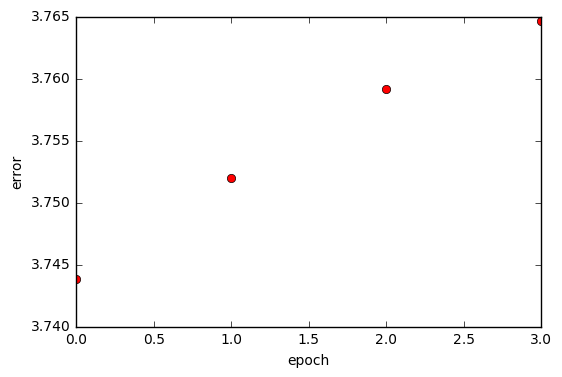

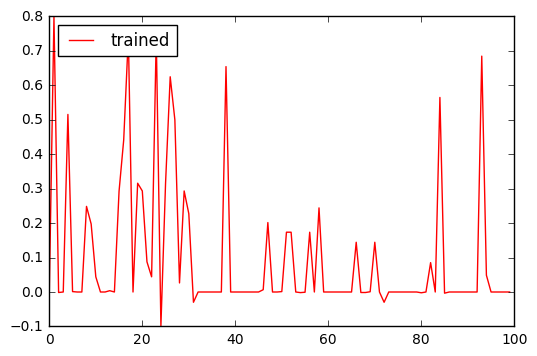

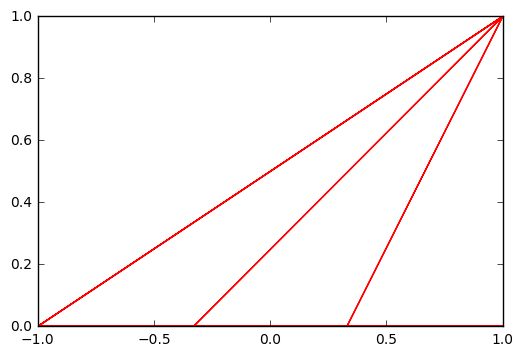

In [19]:
anf.plotErrors()
anf.plotResults() 

anf.plotMF(X[:,0],len(mf)-1) 

In the above example, I have implemented the anfis code on the fertility data from uci repository and obtained classification on it. We can see the data samples used are close to 100 yet it was able to achieve exceptional accuracy.

In [ ]:
data = np.loadtxt("C:/Users/Yashad/Desktop/git/Artificial-Intelligence/AI_project/acc_gyro.csv", dtype = str, delimiter=',', usecols = (5,6,8,9,10))
data = np.chararray.strip(data[0:],'b')
data = np.chararray.strip(data[0:],"'\'")
updated_data = []
for i in range(200):
    updated_data.append(rd.choice(data))
names = data[0]
np.delete(data,1)
X = np.asarray(updated_data,dtype=float)
T = np.ones(400)
mf = [[['gaussmf',{'mean':-5.3,'sigma':1.5}],['gaussmf',{'mean':-2.8,'sigma':1.5}],['gaussmf',{'mean':0.5,'sigma':1.5}],['gaussmf',{'mean':2.5,'sigma':1.5}],['gaussmf',{'mean':3.5,'sigma':1.5}],['gaussmf',{'mean':4.8,'sigma':1.5}]],
     [['gaussmf',{'mean':-2.66,'sigma':1.5}],['gaussmf',{'mean':-0.65,'sigma':1.5}],['gaussmf',{'mean':2.75,'sigma':1.5}]],
     [['gaussmf',{'mean':-3.5,'sigma':1.5}],['gaussmf',{'mean':-0.95,'sigma':1.5}],['gaussmf',{'mean':1.2,'sigma':1.5}], ['gaussmf',{'mean':3.5,'sigma':1.5}]],
     [['gaussmf',{'mean':-9.5,'sigma':2.0}],['gaussmf',{'mean':-6.5,'sigma':2.0}],['gaussmf',{'mean':-3.5,'sigma':2.0}],['gaussmf',{'mean':-0.5,'sigma':2.0}],['gaussmf',{'mean':2.5,'sigma':2.0}],['gaussmf',{'mean':5.5,'sigma':2.0}],['gaussmf',{'mean':8.5,'sigma':2.0}]],
     [['gaussmf',{'mean':-9.5,'sigma':2.0}],['gaussmf',{'mean':-6.5,'sigma':2.0}],['gaussmf',{'mean':-3.5,'sigma':2.0}],['gaussmf',{'mean':-0.5,'sigma':2.0}],['gaussmf',{'mean':2.5,'sigma':2.0}],['gaussmf',{'mean':5.5,'sigma':2.0}],['gaussmf',{'mean':8.5,'sigma':2.0}]]]
mfc = mfunc.MemFuncs(mf)
anf = anfis.ANFIS(X, T, mfc)
anf.trainHybridJangOffLine(epochs=5)
print (round(anf.consequents[-1][0],6))
print (round(anf.consequents[-2][0],6))
print (round(anf.fittedValues[9][0],6))

anf.plotErrors()
anf.plotResults() 

anf.plotMF(X[:,0],len(mf))

#### Results from Fuzzy Neural Network

* In the code above, I have designed a fuzzy inference system for 5 inputs. Accx, Accy, Accz, gyrox and gyroy which are essential for getting the angle between the axis of the robot and normal. 
* As we have seen, we have almost 88000 instances in the data but the fuzzy logic couldn't handle those many instances with five membership functions and was giving memory error.
* I worked through the problem and tried different configurations in the system. I observed that it works well even with less number of instances so to work through the memory error, I tried the problem with just 200 instances. Irrespective of this, it gave me an memory error.
* While taking a deep look into the problem, I observed that code was appending a large amount of data and this appending was directly propotional to the number of membership functions and the number of instances.
* Thus, for the code to work, I tried with three membership functions, and it worked. But unfortunately, to design the self-balancing robot, we need at least five values from accelerometer and gyroscope. This can precisely define the problem and give us an accurate solution. 
* I tried memory managing the code but it was out of scope and for the duration alloted was not possible to achieve that objective.

### Vrep Simulation software

V-REP's strength comes from several features:
* V-REP provides a unified framework combining many powerful internal and external libraries that are often useful for robotics simulations. This includes dynamic simulation engines, forward/inverse kinematics tools, collision detection libraries, vision sensor simulations, path planning, GUI development tools, and built-in models of many common robots.
* V-REP is highly extensible. V-REP developers provide an API that allows one to write custom plugins that add new features. You can embed Lua scripts directly into a simulation scene that, for example, process simulated sensor data, run control algorithms, implement user interfaces, or even send data to a physical robot. They also provide a remote API that allows one to develop standalone applications in many programming languages that are able to pass data in and out of a running V-REP simulation.
* V-REP is cross-platform, mostly open-source, and provides a free educational license.

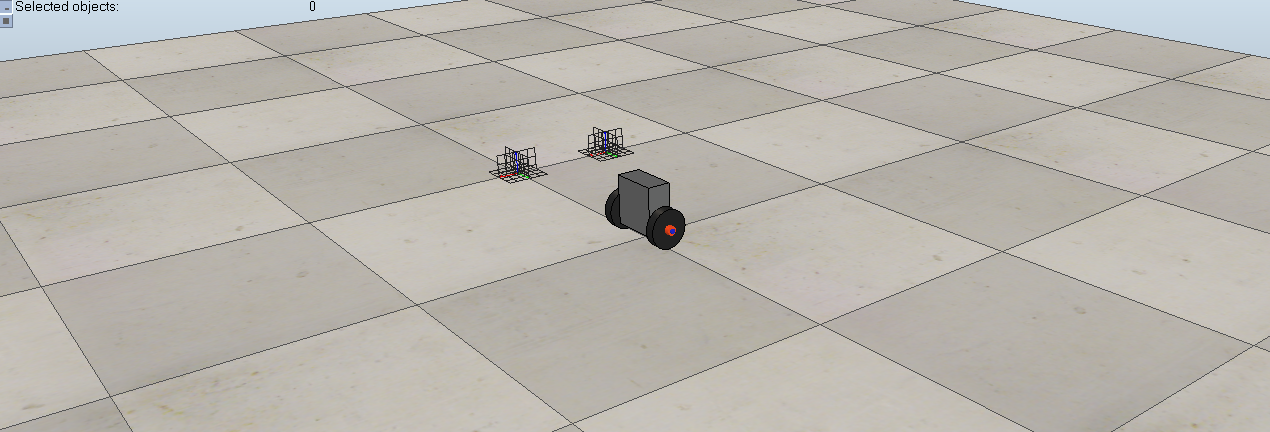

In [20]:
Image("C:/Users/Yashad/Pictures/Capture1.png")

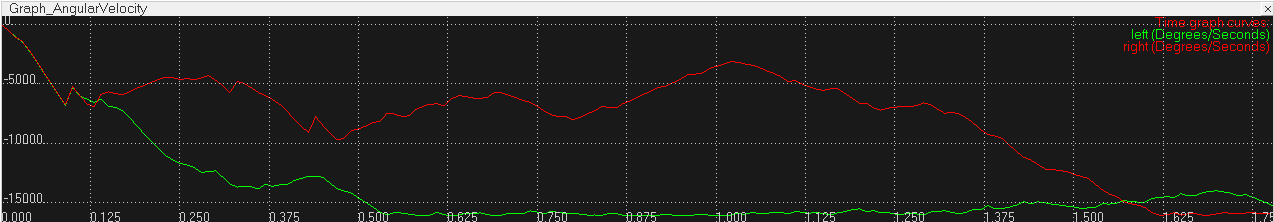

In [21]:
Image("C:/Users/Yashad/Pictures/Capture.png")

#### Results from Vrep

* In Vrep simulation software, I imported the output from the neural network and controlled the torque of the motor using python script.
* We can see the change in angular velocity of the right and left motor on the basis of the change in angle between axis of the bot and normal in the graph above.

### Results

* From the results obtained for different configuration, we can observe that [20,20] provides the best output with train error of  2.43 and test error of 2.45.
* We can also see that the time taken increases with the increase in complexity of the neural network. Thus, the best combination has also taken more time to converge (233s).
* Also, we can see the time taken to obtain optimal result for other configuration.
* In the code above, I have designed a fuzzy inference system for 5 inputs. Accx, Accy, Accz, gyrox and gyroy which are essential for getting the angle between the axis of the robot and normal. 
* As we have seen, we have almost 88000 instances in the data but the fuzzy logic couldn't handle those many instances with five membership functions and was giving memory error.
* I worked through the problem and tried different configurations in the system. I observed that it works well even with less number of instances so to work through the memory error, I tried the problem with just 200 instances. Irrespective of this, it gave me an memory error.
* While taking a deep look into the problem, I observed that code was appending a large amount of data and this appending was directly propotional to the number of membership functions and the number of instances.
* Thus, for the code to work, I tried with three membership functions, and it worked. But unfortunately, to design the self-balancing robot, we need at least five values from accelerometer and gyroscope. This can precisely define the problem and give us an accurate solution. 
* I tried memory managing the code but it was out of scope and for the duration alloted was not possible to achieve that objective.
* In Vrep simulation software, I imported the output from the neural network and controlled the torque of the motor using python script.
* We can see the change in angular velocity of the right and left motor on the basis of the change in angle between axis of the bot and normal in the graph above.

### Future Scope

* Design of this code only controls the balancing of the robot by changing the torque of the motors using the neural network for faster response time than PID controllers.
* If I were to obtain the result by using Fuzzy Neural Network, I would have gained more flexibility and obtained much more accurate results. Fuzzy logic handles the non-linearity constraint better than tradition neural networks. If I would got more time, I would have worked a way through the memory error and obtained the results.
* As mentioned earlier, the control of the robot is solely based on the angle between the axis of the bot and normal. But if we use reinforcement learning on top of neural networks, we can obtain convergence quicker and it will also take into consideration the abnormalities in the environment.

### Conclusion

* Developed a system which takes time to train but while testing gives output atleast 0.3 seconds earlier than PID controller. 
* System is easy to design and there are no manipulations when compared to PID.
* Implemented a self-balancing robot using neural networks and ran the code on a pi which has only 1GB RAM. It took some modifications in the code but it worked. 
* Also, a 250MB swap file was created which creates a virtual memory partition on the external memory card and considers it as RAM. 
* Obtained simulation results on Vrep software by controlling the motors of the robot using the angles from the neural networks.

### References

* http://ieeexplore.ieee.org/document/7858451/?reload=true
* http://ieeexplore.ieee.org/document/4667312/
* https://en.wikipedia.org/wiki/Reinforcement_learning
* https://www.hindawi.com/journals/afs/2013/581879/
* https://en.wikipedia.org/wiki/Fuzzy_logic
* https://in.mathworks.com/help/fuzzy/anfis.html
* http://www.scholarpedia.org/article/Fuzzy_neural_network
* https://github.com/famalgosner/roboticsControl
* https://courses.cit.cornell.edu/ece5990/ECE5990_Fall15_FinalProjects/Yuzhuo_Sun/ECE5990_project_demo/design.html
* https://www.invensense.com/products/motion-tracking/6-axis/mpu-6050/
* http://blog.bitify.co.uk/2013/11/interfacing-raspberry-pi-and-mpu-6050.html

In [26]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Samant-project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Samant-project.ipynb is 2326
